# Preparing the dataset

In [17]:
#Import Python 3's print function and division
from __future__ import print_function, division

# Import GDAL, NumPy, and matplotlib
from osgeo import gdal, gdal_array
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

-----------

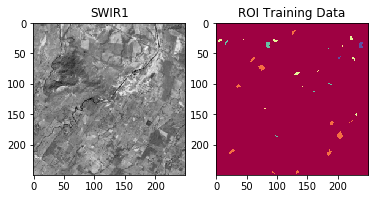

(250, 250, 8)
(250, 250)


In [87]:
# Tell GDAL to throw Python exceptions, and register all drivers
gdal.UseExceptions()
gdal.AllRegister()

# Read in our image and ROI image
img_ds = gdal.Open('data1/LE70220491999322EDC01_stack.gtif', gdal.GA_ReadOnly)
roi_ds = gdal.Open('data1/training_data.gtif', gdal.GA_ReadOnly)

img = np.zeros((img_ds.RasterYSize, img_ds.RasterXSize, img_ds.RasterCount),
               gdal_array.GDALTypeCodeToNumericTypeCode(img_ds.GetRasterBand(1).DataType))
for b in range(img.shape[2]):
    img[:, :, b] = img_ds.GetRasterBand(b + 1).ReadAsArray()
    
roi = roi_ds.GetRasterBand(1).ReadAsArray().astype(np.uint8)

# Display them
plt.subplot(121)
plt.imshow(img[:, :, 4], cmap=plt.cm.Greys_r)
plt.title('SWIR1')

plt.subplot(122)
plt.imshow(roi, cmap=plt.cm.Spectral)
plt.title('ROI Training Data')

plt.show()

print(img.shape)
print(roi.shape)

In [20]:
# Find how many non-zero entries we have -- i.e. how many training data samples?
n_samples = (roi > 0).sum()
print('We have {n} samples'.format(n=n_samples))

# What are our classification labels?
labels = np.unique(roi[roi > 0])
print('The training data include {n} classes: {classes}'.format(n=labels.size, 
                                                                classes=labels))
# We will need a "X" matrix containing our features, and a "y" array containing our labels
#     These will have n_samples rows
#     In other languages we would need to allocate these and them loop to fill them, but NumPy can be faster

X = img[roi > 0, :]  # include 8th band, which is Fmask, for now
y = roi[roi > 0]

print('Our X matrix is sized: {sz}'.format(sz=X.shape))
print('Our y array is sized: {sz}'.format(sz=y.shape))

# Mask out clouds, cloud shadows, and snow using Fmask
clear = X[:, 7] <= 1

X = X[clear, :7]  # we can ditch the Fmask band now
y = y[clear]

print('After masking, our X matrix is sized: {sz}'.format(sz=X.shape))
print('After masking, our y array is sized: {sz}'.format(sz=y.shape))

We have 718 samples
The training data include 5 classes: [1 2 3 4 5]
Our X matrix is sized: (718, 8)
Our y array is sized: (718,)
After masking, our X matrix is sized: (718, 7)
After masking, our y array is sized: (718,)


In [29]:
from sklearn.ensemble import RandomForestClassifier

# Initialize our model with 500 trees
rf = RandomForestClassifier(n_estimators=500, oob_score=True)

# Fit our model to training data
rf = rf.fit(X, y)

In [31]:
print('Our OOB prediction of accuracy is: {oob}%'.format(oob=rf.oob_score_ * 100))

Our OOB prediction of accuracy is: 98.46796657381616%


In [32]:
bands = [1, 2, 3, 4, 5, 7, 6]

for b, imp in zip(bands, rf.feature_importances_):
    print('Band {b} importance: {imp}'.format(b=b, imp=imp))

Band 1 importance: 0.12259253586824076
Band 2 importance: 0.19492474482978886
Band 3 importance: 0.12293940969891472
Band 4 importance: 0.10573868131189737
Band 5 importance: 0.2025844835512095
Band 7 importance: 0.1612543859641945
Band 6 importance: 0.08996575877575426


In [33]:
import pandas as pd

# Setup a dataframe -- just like R
df = pd.DataFrame()
df['truth'] = y
df['predict'] = rf.predict(X)

# Cross-tabulate predictions
print(pd.crosstab(df['truth'], df['predict'], margins=True))

predict    1   2    3    4   5  All
truth                              
1        383   0    0    0   0  383
2          0  16    0    0   0   16
3          0   0  145    0   0  145
4          0   0    0  106   0  106
5          0   0    0    0  68   68
All      383  16  145  106  68  718


In [34]:
# Take our full image, ignore the Fmask band, and reshape into long 2d array (nrow * ncol, nband) for classification
new_shape = (img.shape[0] * img.shape[1], img.shape[2] - 1)

img_as_array = img[:, :, :7].reshape(new_shape)
print('Reshaped from {o} to {n}'.format(o=img.shape,
                                        n=img_as_array.shape))

# Now predict for each pixel
class_prediction = rf.predict(img_as_array)

# Reshape our classification map
class_prediction = class_prediction.reshape(img[:, :, 0].shape)

Reshaped from (250, 250, 8) to (62500, 7)


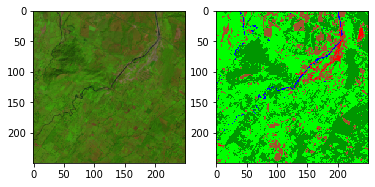

In [35]:
# Visualize

# First setup a 5-4-3 composite
def color_stretch(image, index, minmax=(0, 10000)):
    colors = image[:, :, index].astype(np.float64)

    max_val = minmax[1]
    min_val = minmax[0]

    # Enforce maximum and minimum values
    colors[colors[:, :, :] > max_val] = max_val
    colors[colors[:, :, :] < min_val] = min_val

    for b in range(colors.shape[2]):
        colors[:, :, b] = colors[:, :, b] * 1 / (max_val - min_val)
        
    return colors
    
img543 = color_stretch(img, [4, 3, 2], (0, 8000))

# See https://github.com/matplotlib/matplotlib/issues/844/
n = class_prediction.max()
# Next setup a colormap for our map
colors = dict((
    (0, (0, 0, 0, 255)),  # Nodata
    (1, (0, 150, 0, 255)),  # Forest
    (2, (0, 0, 255, 255)),  # Water
    (3, (0, 255, 0, 255)),  # Herbaceous
    (4, (160, 82, 45, 255)),  # Barren
    (5, (255, 0, 0, 255))  # Urban
))
# Put 0 - 255 as float 0 - 1
for k in colors:
    v = colors[k]
    _v = [_v / 255.0 for _v in v]
    colors[k] = _v
    
index_colors = [colors[key] if key in colors else 
                (255, 255, 255, 0) for key in range(1, n + 1)]
cmap = plt.matplotlib.colors.ListedColormap(index_colors, 'Classification', n)

# Now show the classmap next to the image
plt.subplot(121)
plt.imshow(img543)

plt.subplot(122)
plt.imshow(class_prediction, cmap=cmap, interpolation='none')

plt.show()

------------

In [89]:
# Tell GDAL to throw Python exceptions, and register all drivers
gdal.UseExceptions()
gdal.AllRegister()

# Read in our image and ROI image
img_ds = gdal.Open('/Users/Attawutn/Desktop/Pilot_Sentinel1/Test_data_sentinel1/subset_0_of_S1B_IW_GRDH_1SDV_20200210T230834_20200210T230859_020213_02645C_DCDF_TNR_Orb_Cal_Spk_TC.tif', gdal.GA_ReadOnly)
roi_ds = gdal.Open('/Users/Attawutn/Desktop/Pilot_Sentinel1/training_data1.tif', gdal.GA_ReadOnly)

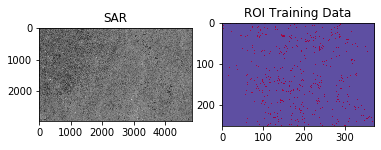

(2934, 4839, 8)
(251, 372)


In [90]:
img = np.zeros((img_ds.RasterYSize, img_ds.RasterXSize, img_ds.RasterCount),
               gdal_array.GDALTypeCodeToNumericTypeCode(img_ds.GetRasterBand(1).DataType))
for b in range(img.shape[2]):
    img[:, :, b] = img_ds.GetRasterBand(b + 1).ReadAsArray()
    
roi = roi_ds.GetRasterBand(1).ReadAsArray().astype(np.uint8)

# Display them
plt.subplot(121)
plt.imshow(img[:, :, 6], cmap=plt.cm.Greys_r)
plt.title('SAR')

plt.subplot(122)
plt.imshow(roi, cmap=plt.cm.Spectral)
plt.title('ROI Training Data')

plt.show()

print(img.shape)
print(roi.shape)

In [82]:
# Find how many non-zero entries we have -- i.e. how many training data samples?
n_samples = (roi >= 1).sum()
print('We have {n} samples'.format(n=n_samples))
labels = np.unique(roi[roi < 128])
print('The training data include {n} classes: {classes}'.format(n=labels.size, classes=labels))
X = img
y = roi
print('Our X matrix is sized: {sz}'.format(sz=X.shape))
print('Our y array is sized: {sz}'.format(sz=y.shape))

We have 93372 samples
The training data include 3 classes: [1 2 3]
Our X matrix is sized: (2934, 4839, 8)
Our y array is sized: (251, 372)


In [85]:
# Find how many non-zero entries we have -- i.e. how many training data samples?
n_samples = (roi >= 1).sum()
print('We have {n} samples'.format(n=n_samples))

# What are our classification labels?
labels = np.unique(roi[roi < 128])
print('The training data include {n} classes: {classes}'.format(n=labels.size, 
                                                                classes=labels))
# We will need a "X" matrix containing our features, and a "y" array containing our labels
#     These will have n_samples rows
#     In other languages we would need to allocate these and them loop to fill them, but NumPy can be faster

X = img[roi > 8, :]  # include 8th band, which is Fmask, for now
y = roi[roi > 0]

print('Our X matrix is sized: {sz}'.format(sz=X.shape))
print('Our y array is sized: {sz}'.format(sz=y.shape))

We have 93372 samples
The training data include 3 classes: [1 2 3]


IndexError: boolean index did not match indexed array along dimension 0; dimension is 2934 but corresponding boolean dimension is 251

In [73]:
# Initialize our model with 500 trees
rf = RandomForestClassifier(n_estimators=500, oob_score=True)

# Fit our model to training data
rf = rf.fit(X, y)

ValueError: Found array with dim 3. Estimator expected <= 2.

In [75]:
import xgboost as xgb
gnb = xgb.XGBClassifier(objective="multi:softprob", random_state=42)
gnb = gnb.fit(X, y)

ValueError: bad input shape (251, 372)

Raster

-----------

## Training the Classifier (Naive Bayes)

In [16]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(X, y)

GaussianNB(priors=None, var_smoothing=1e-09)

In [24]:
from sklearn.ensemble import RandomForestClassifier
gnb = RandomForestClassifier(n_estimators=500,oob_score=True)
gnb = gnb.fit(X,y)

In [24]:
from sklearn.ensemble import GradientBoostingClassifier
gnb = GradientBoostingClassifier()
gnb = gnb.fit(X,y)

In [24]:
import xgboost as xgb
gnb = xgb.XGBClassifier(objective="multi:softprob", random_state=42)
gnb = gnb.fit(X, y)

In [52]:
from sklearn.neural_network import MLPClassifier
gnb = MLPClassifier(hidden_layer_sizes=(8,8,8), activation='relu', solver='adam', max_iter=500)
gnb = gnb.fit(X,y)

C:\Users\attawut\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [64]:
from sklearn import svm
gnb = svm.SVC(decision_function_shape='ovo')
gnb = gnb.fit(X,y)